# 4. Clustering
© Danish Haroon 2017

Danish Haroon, Python Machine Learning Case Studies, https://doi.org/10.1007/978-1-4842-2823-4_4

In [32]:
%matplotlib inline

import operator
import itertools
import numpy as np
import pandas as pd
#from ggplot import *
import seaborn as sns
import matplotlib as mpl
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import euclidean_distances, silhouette_score

rcParams['figure.figsize'] = 15, 5

**Supervised vs. unsupervised learning** (image obtaines from the [book](https://doi.org/10.1007/978-1-4842-2823-4_4))

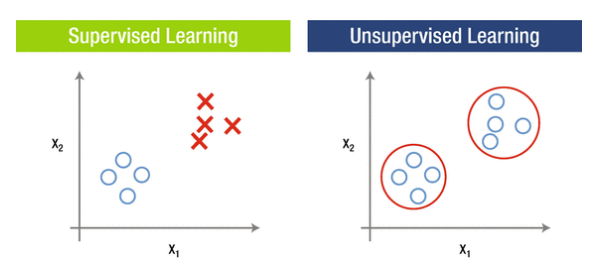

**Load data and subset features**

In [33]:
data_train = pd.read_csv('[UCI] AAAI-14 Accepted Papers - Papers.csv')
data_train = data_train[['title', 'groups', 'keywords', 'topics']]

In [34]:
print(len(data_train))
data_train.head()

398


,title,groups,keywords,topics
0,Kernelized Bayesian Transfer Learning,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...
1,"""Source Free"" Transfer Learning for Text Class...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...
2,A Generalization of Probabilistic Serial to Ra...,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting
3,Lifetime Lexical Variation in Social Media,NLP and Text Mining (NLPTM),Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...
4,Hybrid Singular Value Thresholding for Tensor ...,Knowledge Representation and Reasoning (KRR)\n...,tensor completion\nlow-rank recovery\nhybrid s...,KRR: Knowledge Representation (General/Other)\...


**Stretch data row-wise as a function of groups**

In [35]:
s = data_train['groups'].str.split('\n').apply(pd.Series).stack()
s.index = s.index.droplevel(-1)
s.name = 'groups'
del data_train['groups']
data_train = data_train.join(s).reset_index()

**Add new variable for group membership**

In [36]:
data_train['flags'] = pd.Series(np.ones(len(data_train)), index=data_train.index)
data_train.head()

,index,title,keywords,topics,groups,flags
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0


**Define function for matrix creation**

In [37]:
def matrix_from_df(data_train):

    matrix = data_train.pivot_table(index = ['title'], columns=['groups'], values='flags')
    matrix = matrix.fillna(0).reset_index()
    x_cols = matrix.columns[1:]
    return matrix, x_cols

**Retrieve matrix and x columns**

In [49]:
matrix, x_cols = matrix_from_df(data_train)
matrix.head()

groups,title,AI and the Web (AIW),Applications (APP),Cognitive Modeling (CM),Cognitive Systems (CS),Computational Sustainability and AI (CSAI),Game Playing and Interactive Entertainment (GPIE),Game Theory and Economic Paradigms (GTEP),Heuristic Search and Optimization (HSO),Human-Computation and Crowd Sourcing (HCC),...,Multiagent Systems (MAS),NLP and Knowledge Representation (NLPKR),NLP and Machine Learning (NLPML),NLP and Text Mining (NLPTM),Novel Machine Learning Algorithms (NMLA),Planning and Scheduling (PS),Reasoning under Uncertainty (RU),Robotics (ROB),Search and Constraint Satisfaction (SCS),Vision (VIS)
0,"""Source Free"" Transfer Learning for Text Class...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,A Characterization of the Single-Peaked Single...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"A Computational Method for (MSS,CoMSS) Partiti...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,A Control Dichotomy for Pure Scoring Rules,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Convex Formulation for Semi-supervised Multi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Clustering Models

**Apply elbow method on data matrix**

Text(0.5, 1.0, 'Elbow for KMeans clustering')

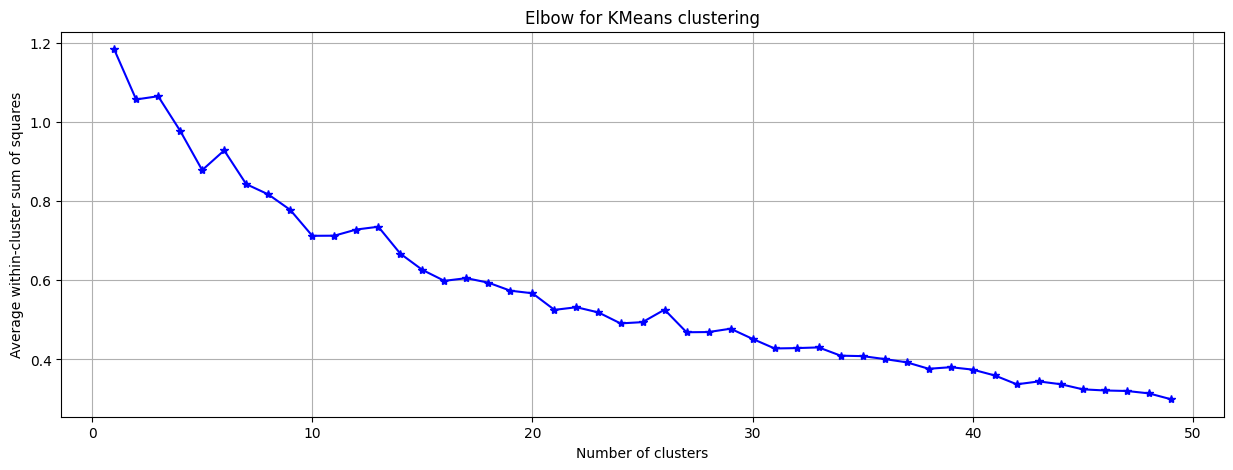

In [39]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]

K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

**Apply variance explained on data matrix**

Text(0.5, 1.0, 'Elbow for KMeans clustering')

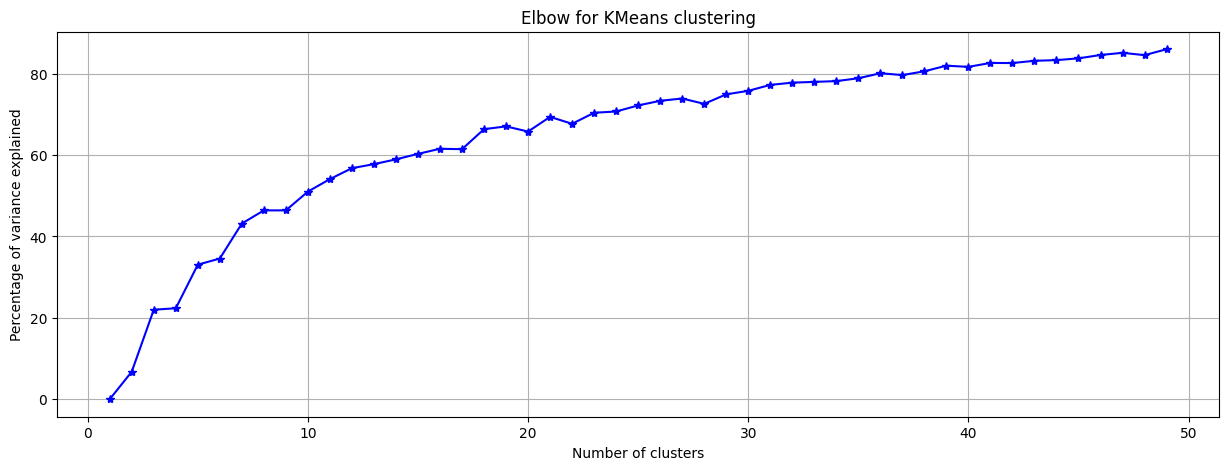

In [40]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]

K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]

wcss = [sum(d**2) for d in dist]
tss = sum(pdist(X)**2)/X.shape[0]
bss = tss-wcss

kIdx = 10-1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Elbow for KMeans clustering')

**Training k-means model for cluster size of 9**

In [41]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]

cluster = KMeans(n_clusters = 9, random_state = 2)
matrix['cluster'] = cluster.fit_predict(X)
matrix.cluster.value_counts()

cluster
3    128
7     45
0     42
5     41
2     32
6     32
4     32
8     30
1     14
Name: count, dtype: int64

**Principal Component Analysis to group related features into two components**

In [46]:
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['title', 'cluster', 'x', 'y']]
customer_clusters.head()

groups,title,cluster,x,y
0,"""Source Free"" Transfer Learning for Text Class...",0,0.615810,-0.060295
1,A Characterization of the Single-Peaked Single...,2,-0.756838,0.971322
2,"A Computational Method for (MSS,CoMSS) Partiti...",7,-0.287956,-0.216148
3,A Control Dichotomy for Pure Scoring Rules,6,-0.521295,0.570206
4,A Convex Formulation for Semi-supervised Multi...,5,0.198578,-0.129668


**Plot clusters in a two-dimensional space**

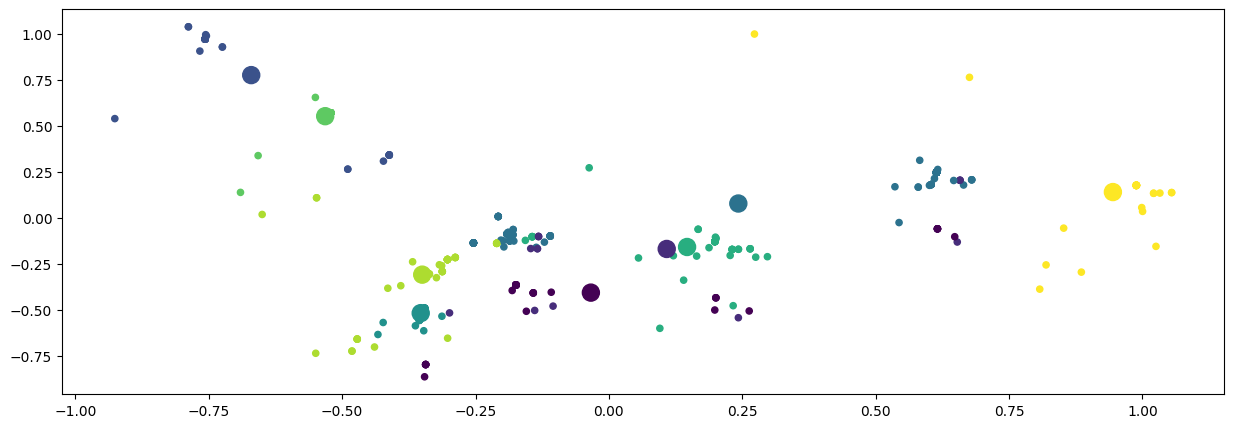

In [59]:
cluster_centers_data = pd.DataFrame(cluster.cluster_centers_, columns=matrix.columns[1:])
cluster_centers_transformed = pca.transform(cluster_centers_data)

cluster_centers = pd.DataFrame(cluster_centers_transformed, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))

plt.scatter(customer_clusters['x'], customer_clusters['y'], s = 20, c=customer_clusters['cluster'])
plt.scatter(cluster_centers['x'], cluster_centers['y'], s = 150, c=cluster_centers['cluster'])

**Merge matrix into original data frame**

In [15]:
customer_clusters.columns.name = None
df = data_train.merge(customer_clusters, on='title')
df.head()

,index,title,keywords,topics,groups,flags,cluster,x,y
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0,3,0.613870,0.245408
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0,0,0.615810,-0.060295
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0,0,0.615810,-0.060295
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0,6,-0.521295,0.570206
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0,3,-0.183192,-0.090091


**Define function to generate Wordcloud**

In [16]:
def wordcloud_object(word_string):

    FONT_ROOT = './fonts/'
    wordcloud = WordCloud(font_path=FONT_ROOT + 'arial.ttf',stopwords=STOPWORDS, background_color='black', width=1200, height=1000).generate(' '.join(word_string))
    return wordcloud

**Create function to plot Wordcloud for each cluster**

In [17]:
def plot_wordcloud(df, clusters, pivot):

    fig = plt.figure(figsize=(15,29.5))
    for cluster in range(clusters):
        List_ = []

        for x in df[df['cluster']==cluster][pivot]:
            try:
                List_.extend(x.split('\n'))
            except:
                pass

        if List_:
            ax = fig.add_subplot(5,2,cluster+1)
            wordcloud = wordcloud_object(List_)
            plt.title('Cluster: %d'%(cluster+1))
            ax.imshow(wordcloud)
            ax.axis('off')

**Generate Wordclouds of features named *'Keywords'***

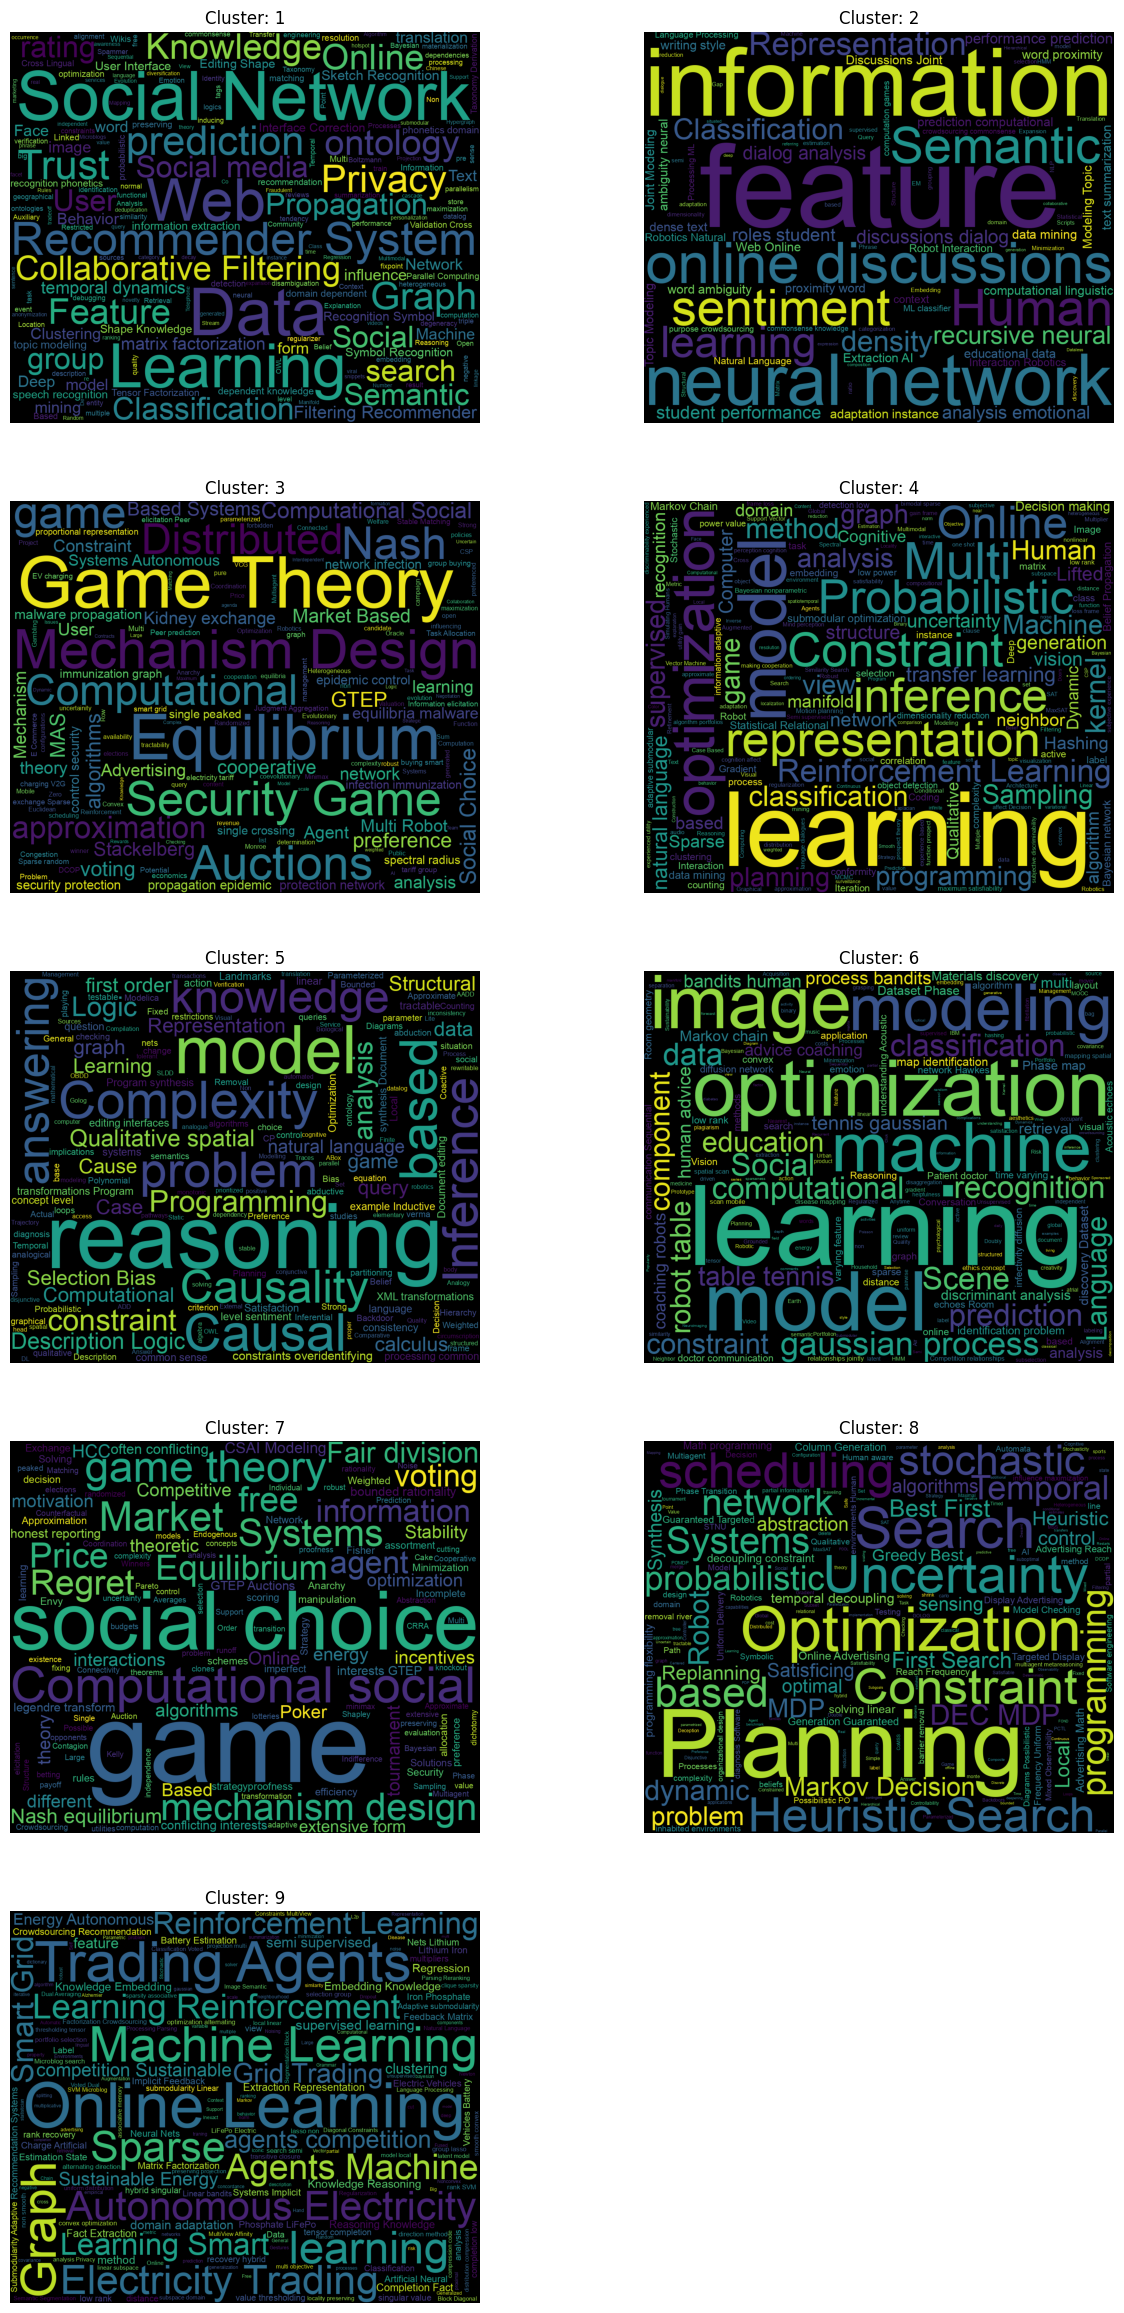

In [18]:
plot_wordcloud(df, cluster.n_clusters, 'keywords')

**Define method to find complete keywords for given clusters and unigrams**

In [19]:
def perform_cluster_group_audit(clusters, term):

    for cluster in clusters:

        df_cluster = df[df['cluster'] == cluster]
        print('Cluster number: %d'%(cluster + 1))
        keywords = list(df_cluster['keywords'])
        keywords = [keyword.split('\n') for keyword in keywords]
        keywords = [item for sublist in keywords for item in sublist]
        keywords = [keyword.lower() for keyword in keywords if term in keyword.lower()]
        keywords_freq = {x:keywords.count(x) for x in keywords}
        print(sorted(keywords_freq.items(), key=operator.itemgetter(1), reverse=True))
        print('\n')

**Find keywords for keyword *search* in clusters 0 and 7**

In [20]:
perform_cluster_group_audit([0, 7], 'search')

Cluster number: 1
[('web search personalization', 1), ('entity search', 1), ('real-time web search', 1), ('search snippets', 1), ('search result diversification', 1)]


Cluster number: 8
[('heuristic search', 12), ('greedy best first search', 4), ('search', 3), ('local search', 2), ('stochastic local search', 2), ('search control', 2), ('and/or search', 2), ('monte carlo tree search', 2), ('incremental search', 1), ('real-time search', 1), ('agent-centered search', 1), ('hierarchical search', 1), ('parallel search', 1), ('bounded suboptimal search', 1), ('best-first search', 1), ('suboptimal heuristic search', 1)]


